<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [41]:
# Import the Required Packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import random
import sys
from tensorflow import keras
from tensorflow.keras import regularizers
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

import warnings
warnings.filterwarnings("ignore") 

# Table Of Contents  <a id="top"></a>
#### 1. [Data loading & Processing](#part1)
   - [1.1 Data Loading](#part1.1)  
   - [1.2 Data Pre-processing](#part1.2)  
   
#### 2. [Develop Character Generator Model](#part2)
       
#### 3. [Use the developed Model to generate the characters / sentences](#part3)

## Step 1 – Data Loading and Processing <a id="part1"></a>

o Open and read the Harry_Potter_Book2.txt file
o Check the total number of characters in the original text
• Data Processing
o Perform basic data cleansing by removing unnecessary characters
o Identify a list of unique characters and punctuations in the clean text
o Prepare data into training text and labels (X & y) using the “sliding window”
method
o Perform one-hot encoding on X & y and convert them into binary arrays

### 1.1 Data Loading <a id="part1.1"></a>

In [42]:
with open("C:\\Users\\xinle\\ASG2 DL\\Harry_Potter_Book2.txt", "r", encoding="utf-8") as f:
    text = f.read()
    
print("The total number of characters in the original text is: ", len(text))

The total number of characters in the original text is:  531708


### 1.2 Data Processing <a id="part1.2"></a>


In [43]:
# Convert to lower case and check first 100 characters 
text = text.lower()
text[1:100]

'j . k . r o w l ! n g \n\nharry \n\npotter \n\n\n\n\n/ \n\n\n\n\nthe worst birthday \n\nnot for the first time, an '

In [44]:
# Remove '\n' from the corpus
text = re.sub('\n','',text)
text[:100]

'j . k . r o w l ! n g harry potter / the worst birthday not for the first time, an argument had brok'

In [45]:
text[800:1000]

' son, dudley. page | 2 harry potter and the chamber of secrets - j.k. rowling “i want more bacon.” “there’s more in the frying pan, sweetums,” said aunt petunia, turning misty eyes on her massive son.'

In [46]:
text  = re.sub(r"page \| \d+ harry potter and the chamber of secrets - j.k. rowling","",text)

In [47]:
text[800:1000]

' son, dudley.  “i want more bacon.” “there’s more in the frying pan, sweetums,” said aunt petunia, turning misty eyes on her massive son. “we must build you up while we’ve got the chance. ... i don’t '

In [48]:
# List of unique characters in the corpus
chars = sorted(list(set(text)))

# Create a dictionary to map unique characters to their index
char_indices = dict((char, chars.index(char)) for char in chars)

print("Unique characters: ", len(chars))
print("Unique character list: ", chars)

Unique characters:  59
Unique character list:  [' ', '!', '"', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|', '—', '‘', '’', '“', '”', '•']


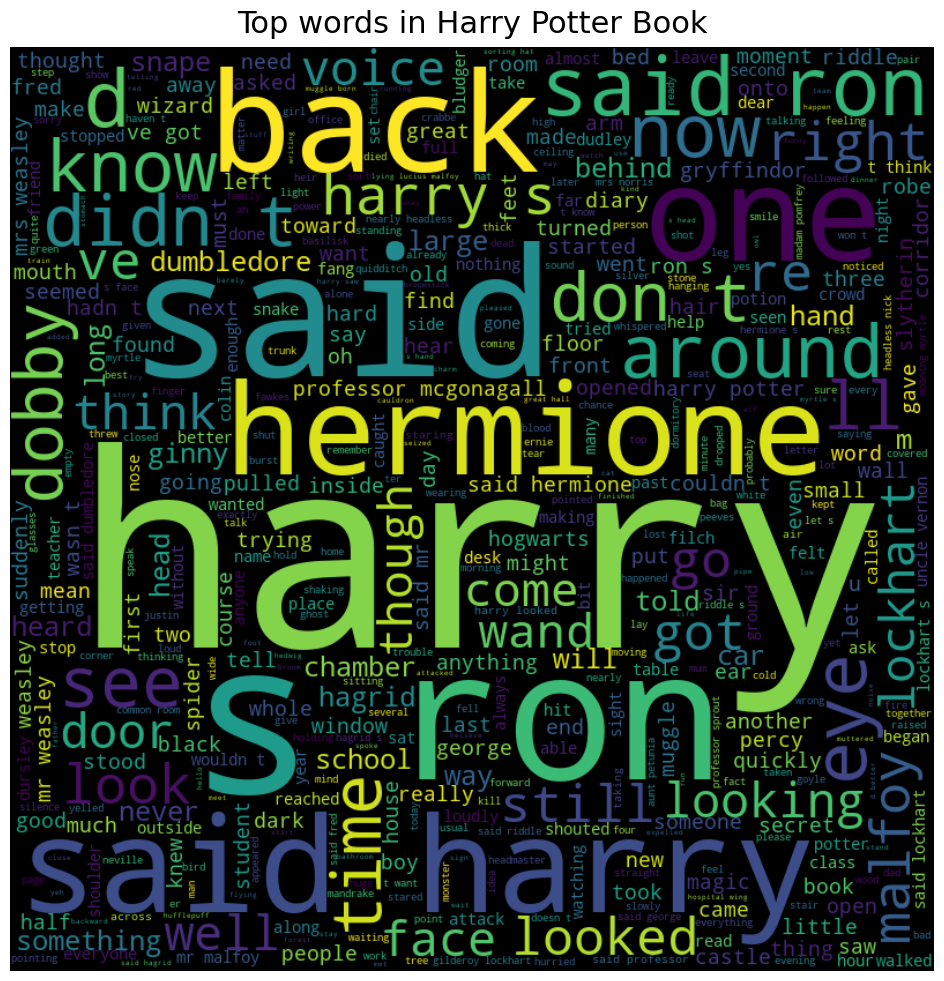

In [49]:
# top words
from wordcloud import WordCloud,STOPWORDS
wc = WordCloud(
    background_color='black',
    max_words=500,
    height=800,
    width=800,
).generate(text)

plt.figure(figsize=(12,12))
plt.title('Top words in Harry Potter Book', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [50]:
window_size = 50
step = 3

sentences = []
next_chars = []

for i in range(0, len(text) - window_size, step):
    sentences.append(text[i: i + window_size])
    next_chars.append(text[i + window_size])
print('Number of sequences:', len(sentences))

Number of sequences: 163564


The choice of window size (maxlen) and step (step) will depend on the desired level of context and granularity for generating the text. A larger maxlen will provide more context to the model, but will also make the training process slower and more computationally expensive. A smaller maxlen will result in less context, but will allow for faster training. Similarly, a smaller step will result in a denser sampling of the text, but will also increase the computational cost.

In general, a good starting point for maxlen might be around 100 characters, which provides a decent amount of context for the model to generate meaningful text. The step size might be set to 1, which means that a new sequence is sampled every character. This ensures that the model sees all possible combinations of characters and punctuations.

However, these values can be adjusted based on the specific requirements of the text generation task and the available computational resources. For example, if the goal is to generate text that is very similar to the original text, a larger maxlen and a smaller step might be preferred. On the other hand, if the goal is to generate text that is more unique, a smaller maxlen and a larger step might be more appropriate.

In [51]:
x = np.zeros((len(sentences), window_size, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print('len(x): ',len(x))
print('x[0]: ',x[0])
print('len(y): ',len(y))
print('y[0]: ',y[0])

len(x):  163564
x[0]:  [[False False False ... False False False]
 [ True False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
len(y):  163564
y[0]:  [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False]


In [52]:
with open("C:\\Users\\xinle\\ASG2 DL\\Book_BleuScore.txt", "r", encoding="utf-8") as f:
    bleu = f.read()
    
print("The total number of characters in the original text is: ", len(bleu))
bleu = bleu.lower()
bleu = re.sub('\n','',bleu)
bleu  = re.sub(r"page \| \d+ harry potter and the philosophers stone - j.k. rowling","",bleu)

The total number of characters in the original text is:  474429


In [53]:
from nltk.translate.bleu_score import corpus_bleu

reference_texts = [bleu]
# Add your reference texts to the list
reference_texts

['/ the boy who lived mr. and mrs. dursley, of number four, privet drive, were proud to say that they were perfectly normal, thank you very much. they were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. mr. dursley was the director of a firm called grunnings, which made drills. he was a big, beefy man with hardly any neck, although he did have a very large mustache. mrs. dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. the dursley s had a small son called dudley and in their opinion there was no finer boy anywhere. the dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. they didn’t think they could bear it if anyone found out about the potters. mrs. potter was mrs. dursley’s sister, but they hadn’

## Step 2 – Develop Character Generator Model <a id="part2"></a>

different sampling function are first created.The stochastic sampling would be used for most models until we tune the hyper paraters for sampling

#### stochastic sampling

In [56]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds) 
    preds = exp_preds / np.sum(exp_preds) 
    probas = np.random.multinomial(1, preds, 1) 
    return np.argmax(probas) 

#### random sampling <a id="rsample"></a>

[To random sampling model](#rsamplec)

In [15]:
def randomsample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

#### greedy sampling <a id="gsample"></a>

[To greedy  sampling model](#gsamplec)

In [16]:
def greedysample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature 
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.argmax(preds)

### Model #1

#### LSTM

In [33]:
model1 = keras.models.Sequential()
model1.add(layers.LSTM(128, input_shape=(window_size, len(chars))))
model1.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model1.compile(loss='categorical_crossentropy', optimizer=optimizer)
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               96256     
                                                                 
 dense_4 (Dense)             (None, 59)                7611      
                                                                 
Total params: 103,867
Trainable params: 103,867
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history = model1.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 1.0, 1.2]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model1.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
            
        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 365s 407ms/step - loss: 1.9282 - val_loss: 1.9068
epoch 2
895/895 [==============================] - 376s 419ms/step - loss: 1.8809 - val_loss: 1.8670
epoch 3
895/895 [==============================] - 473s 529ms/step - loss: 1.8394 - val_loss: 1.8355
epoch 4
895/895 [==============================] - 495s 553ms/step - loss: 1.8045 - val_loss: 1.8039
epoch 5
895/895 [==============================] - 528s 590ms/step - loss: 1.7722 - val_loss: 1.7778
--- Generating with seed: " on a hogwarts school list. a glass case nearby he"
------ temperature: 0.2
 on a hogwarts school list. a glass case nearby he said to a think to the seard the sard to a faid the ever and harry been said he said it and harry and harry had had been the care and harry and harry had said the care was the said harry sores and harry said harry said harry and harry sore the said the sear and harry had harry and harry and hermione the had hermione the cander the from har

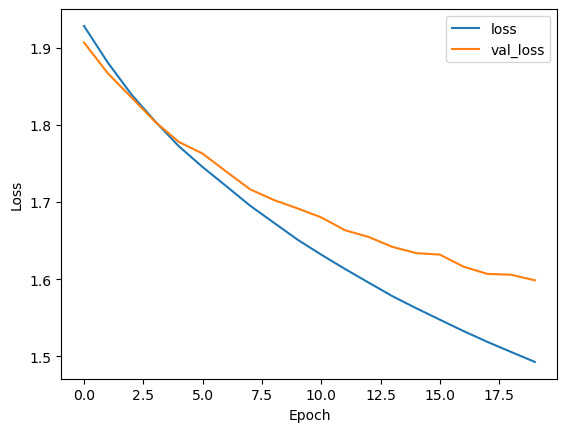

In [37]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #2

#### SimpleRNN

In [84]:
model2 = keras.models.Sequential()
model2.add(layers.SimpleRNN(128, input_shape=(window_size, len(chars))))
model2.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer)
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 128)               24064     
                                                                 
 dense_5 (Dense)             (None, 59)                7611      
                                                                 
Total params: 31,675
Trainable params: 31,675
Non-trainable params: 0
_________________________________________________________________


In [85]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model2.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 1.0, 1.2]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model2.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 290s 323ms/step - loss: 2.5226 - val_loss: 2.2333
epoch 2
895/895 [==============================] - 293s 327ms/step - loss: 2.1644 - val_loss: 2.1183
epoch 3
895/895 [==============================] - 347s 388ms/step - loss: 2.0592 - val_loss: 2.0227
epoch 4
895/895 [==============================] - 362s 404ms/step - loss: 1.9791 - val_loss: 1.9734
epoch 5
895/895 [==============================] - 336s 375ms/step - loss: 1.9154 - val_loss: 1.9135
--- Generating with seed: "i have given my permission.” harry and ron walked "
------ temperature: 0.2
i have given my permission.” harry and ron walked the said harry said harry head and he was dore of harry said harry and harry had he was a look a durnges a sere the still a dor a dor the said harry had a pooned he was a look a the care the said harry had harry and harry had the said harry and he was a the said harry said hermione harry has a and he was a dor the and he was dobby as the go

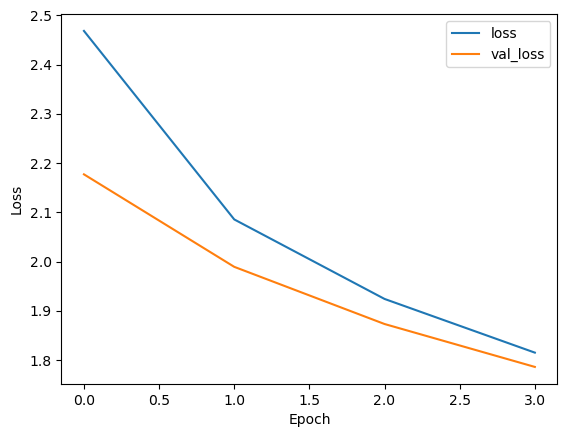

In [88]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #3

#### GRU

In [89]:
model3 = keras.models.Sequential()
model3.add(layers.GRU(128, input_shape=(window_size, len(chars))))
model3.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer)
model3.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               72576     
                                                                 
 dense_7 (Dense)             (None, 59)                7611      
                                                                 
Total params: 80,187
Trainable params: 80,187
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model3.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 1.0, 1.2]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model3.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 977s 1s/step - loss: 2.4737 - val_loss: 2.1830
epoch 2
895/895 [==============================] - 1321s 1s/step - loss: 2.0868 - val_loss: 1.9925
epoch 3
895/895 [==============================] - 967s 1s/step - loss: 1.9223 - val_loss: 1.8686
epoch 4
895/895 [==============================] - 1544s 2s/step - loss: 1.8088 - val_loss: 1.7812
epoch 5
895/895 [==============================] - 1724s 2s/step - loss: 1.7261 - val_loss: 1.7261
--- Generating with seed: "ked you to stay about twelve times, and then dad c"
------ temperature: 0.2
ked you to stay about twelve times, and then dad come a sight of the could he was a perely and harry past of the car the start of the car of the stopled and harry putter and said harry bean start of the start of the car harry and harry door was start of the car the ron said harry and harry patch of the could he was a looking and harry was a look and ron in the start of the could he said harry potter a

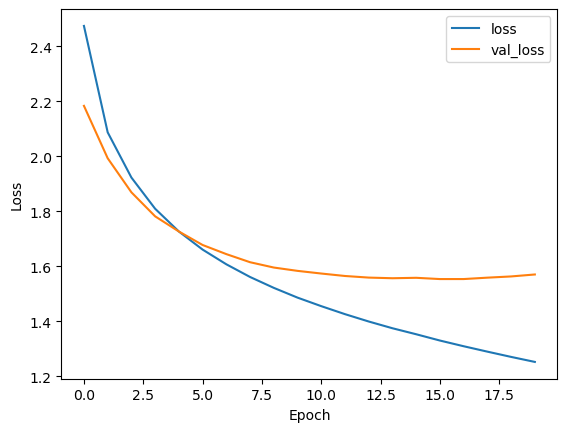

In [91]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #4

#### Bidirectional

In [92]:
model4 = keras.models.Sequential()
model4.add(layers.Bidirectional(LSTM(128, input_shape=(None,window_size, len(chars)))))
model4.build(input_shape=(None,window_size, len(chars)))
model4.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model4.compile(loss='categorical_crossentropy', optimizer=optimizer)
model4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 256)              192512    
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 59)                15163     
                                                                 
Total params: 207,675
Trainable params: 207,675
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history = model4.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 1.0, 1.2]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model4.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()
        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 1353s 2s/step - loss: 2.5837 - val_loss: 2.2602
epoch 2
895/895 [==============================] - 1331s 1s/step - loss: 2.1729 - val_loss: 2.0826
epoch 3
895/895 [==============================] - 1337s 1s/step - loss: 2.0181 - val_loss: 1.9566
epoch 4
895/895 [==============================] - 1326s 1s/step - loss: 1.9112 - val_loss: 1.8710
epoch 5
895/895 [==============================] - 1325s 1s/step - loss: 1.8308 - val_loss: 1.8180
--- Generating with seed: "gh. mr. weasley glanced at his watch and then at h"
------ temperature: 0.2
gh. mr. weasley glanced at his watch and then at he say had been the stope the stall no let he said and marted the care can the stope had be the stope the stare and stiffing the stall a the stopt the stood his said the store the slat he was still stome harry head he was dong the stopped the care the started and the stor the stare for the stall of the stope to stope the stall he stope the carss and h

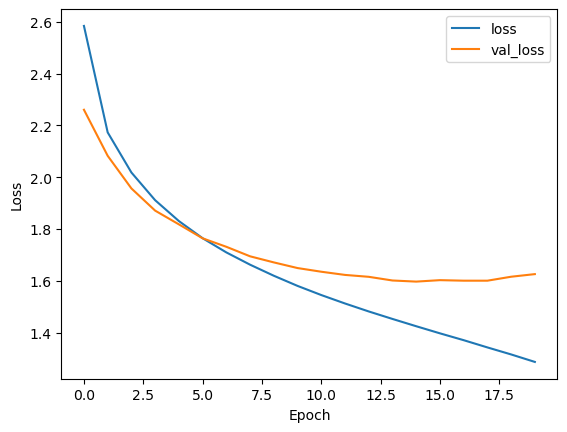

In [94]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #5

#### Learning rate: 0.01

In [43]:
model5 = keras.models.Sequential()
model5.add(layers.GRU(128, input_shape=(window_size, len(chars))))
model5.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.01)
model5.compile(loss='categorical_crossentropy', optimizer=optimizer)
model5.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 128)               72576     
                                                                 
 dense_5 (Dense)             (None, 59)                7611      
                                                                 
Total params: 80,187
Trainable params: 80,187
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model5.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 1.0, 1.2]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model5.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 620s 680ms/step - loss: 2.0025 - val_loss: 1.7502
epoch 2
895/895 [==============================] - 643s 719ms/step - loss: 1.6861 - val_loss: 1.6585
epoch 3
895/895 [==============================] - 637s 712ms/step - loss: 1.5989 - val_loss: 1.6435
epoch 4
895/895 [==============================] - 406s 453ms/step - loss: 1.5569 - val_loss: 1.6128
epoch 5
895/895 [==============================] - 439s 491ms/step - loss: 1.5311 - val_loss: 1.5920
--- Generating with seed: "n appointed head boy. harry didn’t realize what he"
------ temperature: 0.2
n appointed head boy. harry didn’t realize what he had been to the door to the while a something to the couldle the dursleys and he seemed to the door had been out of the come of the door the door the door he was the door the door to going to the door to the durgen of the dursleys and the dursleys and the door had been to the door the door had been to the come of the dursleys was to dobby 

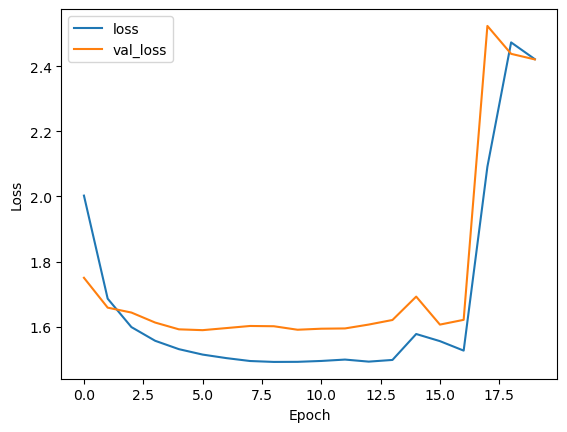

In [45]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #6

#### Learning rate= 0.0001

In [49]:
model6 = keras.models.Sequential()
model6.add(layers.GRU(128, input_shape=(window_size, len(chars))))
model6.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.0001)
model6.compile(loss='categorical_crossentropy', optimizer=optimizer)
model6.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128)               72576     
                                                                 
 dense_7 (Dense)             (None, 59)                7611      
                                                                 
Total params: 80,187
Trainable params: 80,187
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model6.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.2, 0.5, 1.0, 1.2]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model6.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 1102s 1s/step - loss: 3.1065 - val_loss: 2.8624
epoch 2
895/895 [==============================] - 1135s 1s/step - loss: 2.7505 - val_loss: 2.6194
epoch 3
895/895 [==============================] - 1199s 1s/step - loss: 2.5546 - val_loss: 2.4697
epoch 4
895/895 [==============================] - 1303s 1s/step - loss: 2.4366 - val_loss: 2.3789
epoch 5
895/895 [==============================] - 957s 1s/step - loss: 2.3613 - val_loss: 2.3187
--- Generating with seed: "y do you mean by the ‘horror within’ the chamber?”"
------ temperature: 0.2
y do you mean by the ‘horror within’ the chamber?” saing and he the the wing hare sar the the mare the the the the the the the the se the couthe the the the the the he the the sout the the the the the the he the har the the se the the she the the to the the sere the sard the the the the the the the the the the the sare the the the he the the he the the the the the the the the the the the the the se t

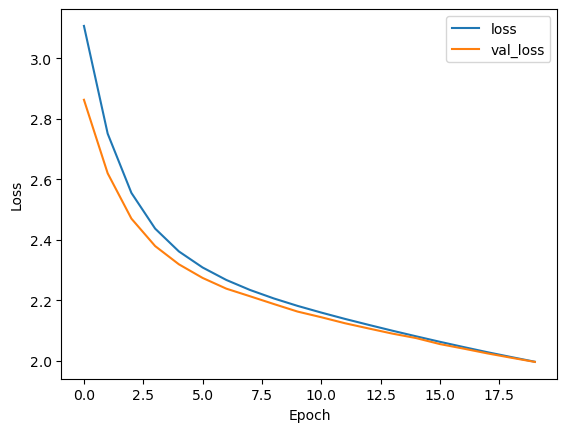

In [51]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #7

#### Batch size: 64

In [20]:
model7 = keras.models.Sequential()
model7.add(layers.GRU(128, input_shape=(window_size, len(chars))))
model7.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model7.compile(loss='categorical_crossentropy', optimizer=optimizer)
model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128)               72576     
                                                                 
 dense_1 (Dense)             (None, 59)                7611      
                                                                 
Total params: 80,187
Trainable params: 80,187
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model7.fit(x, y,
              batch_size=64,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model7.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
1789/1789 [==============================] - 254s 142ms/step - loss: 2.2292 - val_loss: 2.0417
epoch 2
1789/1789 [==============================] - 273s 153ms/step - loss: 1.9388 - val_loss: 1.8573
epoch 3
1789/1789 [==============================] - 276s 154ms/step - loss: 1.7893 - val_loss: 1.7541
epoch 4
1789/1789 [==============================] - 282s 158ms/step - loss: 1.6904 - val_loss: 1.6825
epoch 5
1789/1789 [==============================] - 257s 143ms/step - loss: 1.6153 - val_loss: 1.6395
--- Generating with seed: " to hold his  glasses on straight and hoping again"
------ temperature: 0.5
 to hold his  glasses on straight and hoping against from the start to coming to moke stad been still be the have every been and herrione stould mading of the classe of the chood weadless and said harry had not the care with of the crowed the classes on the campther sage a his treaging and the cast of hagry, and mrading his faced the start of the cluss start him has been to the c

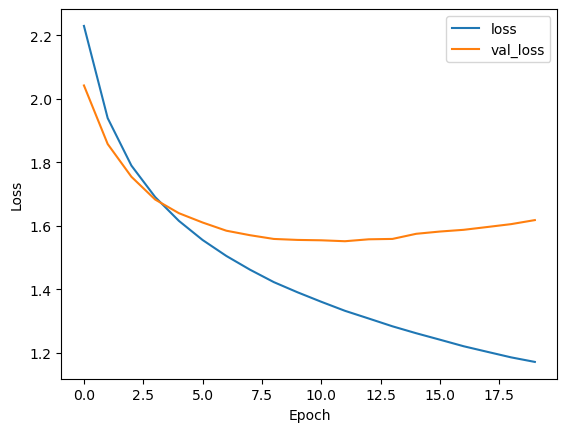

In [23]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #8

#### Batch size: 256

In [24]:
model8 = keras.models.Sequential()
model8.add(layers.GRU(128, input_shape=(window_size, len(chars))))
model8.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model8.compile(loss='categorical_crossentropy', optimizer=optimizer)
model8.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 128)               72576     
                                                                 
 dense_2 (Dense)             (None, 59)                7611      
                                                                 
Total params: 80,187
Trainable params: 80,187
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model8.fit(x, y,
              batch_size=256,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [ 0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model8.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
448/448 [==============================] - 156s 344ms/step - loss: 2.6494 - val_loss: 2.3001
epoch 2
448/448 [==============================] - 145s 324ms/step - loss: 2.2157 - val_loss: 2.1348
epoch 3
448/448 [==============================] - 142s 316ms/step - loss: 2.0801 - val_loss: 2.0248
epoch 4
448/448 [==============================] - 143s 319ms/step - loss: 1.9671 - val_loss: 1.9231
epoch 5
448/448 [==============================] - 146s 325ms/step - loss: 1.8751 - val_loss: 1.8452
--- Generating with seed: "range of hair-care potions — good girl! in fact” —"
------ temperature: 0.5
range of hair-care potions — good girl! in fact” — he was stell be was stoped and head wose for beting of stert to she pading the grobbe the dook the mading the geat for in, was the care wor mant from the dook and and and the leave stoped lott on of the cand with the wall the wand herm on a down’t mart your at the mamper of the wish the stofed the harry was hem in the has it out winss the 

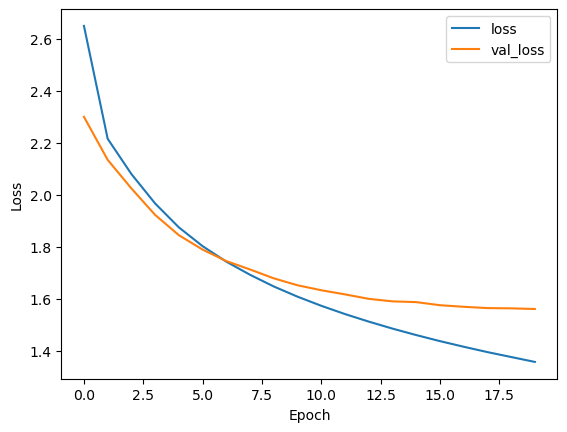

In [26]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #9

#### Hidden units in layers : 256

In [29]:
model9 = keras.models.Sequential()
model9.add(layers.GRU(256, input_shape=(window_size, len(chars))))
model9.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model9.compile(loss='categorical_crossentropy', optimizer=optimizer)
model9.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 256)               243456    
                                                                 
 dense_3 (Dense)             (None, 59)                15163     
                                                                 
Total params: 258,619
Trainable params: 258,619
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model9.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model9.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 392s 436ms/step - loss: 2.4077 - val_loss: 2.1049
epoch 2
895/895 [==============================] - 392s 439ms/step - loss: 1.9912 - val_loss: 1.8818
epoch 3
895/895 [==============================] - 395s 441ms/step - loss: 1.7987 - val_loss: 1.7458
epoch 4
895/895 [==============================] - 428s 479ms/step - loss: 1.6644 - val_loss: 1.6529
epoch 5
895/895 [==============================] - 392s 438ms/step - loss: 1.5588 - val_loss: 1.5936
--- Generating with seed: "ything else to do, and because he wanted to be doi"
------ temperature: 0.5
ything else to do, and because he wanted to be doing them and cold around the doar sproot head harry and hermione said agoing to the erge of harry had in as the shote to the comchion. “we’re porite to sif me the black one of his port mage where and her said hermione it was come was over the scare on a thould the corning into a look of hermione and the berather her had becouss and crobbed b

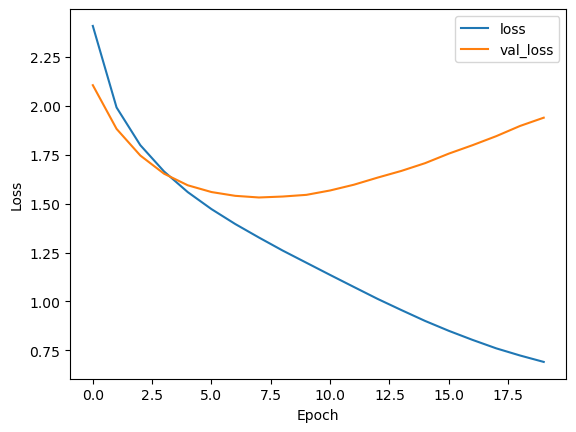

In [31]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #10

#### Number of GRU layers: 2
#### Hidden units: 256, 128

In [33]:
model10 = keras.models.Sequential()
model10.add(layers.GRU(256, input_shape=(window_size, len(chars)), return_sequences = True))
model10.add(layers.GRU(128))
model10.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model10.compile(loss='categorical_crossentropy', optimizer=optimizer)
model10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 50, 256)           243456    
                                                                 
 gru_5 (GRU)                 (None, 128)               148224    
                                                                 
 dense_1 (Dense)             (None, 59)                7611      
                                                                 
Total params: 399,291
Trainable params: 399,291
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model10.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model10.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 426s 472ms/step - loss: 2.2816 - val_loss: 1.9484
epoch 2
895/895 [==============================] - 432s 483ms/step - loss: 1.8236 - val_loss: 1.7216
epoch 3
895/895 [==============================] - 432s 483ms/step - loss: 1.6399 - val_loss: 1.6100
epoch 4
895/895 [==============================] - 400s 447ms/step - loss: 1.5156 - val_loss: 1.5301
epoch 5
895/895 [==============================] - 402s 449ms/step - loss: 1.4192 - val_loss: 1.4944
--- Generating with seed: "unny: every one of the hufflepuffs looked as thoug"
------ temperature: 0.5
unny: every one of the hufflepuffs looked as though the class off it of the car of the school on the car to he was of when streith and said as though he didn’t have anyone in straight borgin into the dramong straiget like a minute of the door and hermione with the back on the dark off the courders of the colar. “but i don’t want an errest bright into the was through hermione seeter potter 

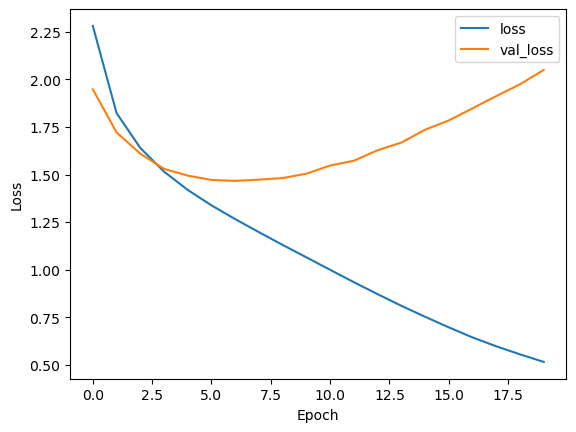

In [35]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #11

#### Number of GRU layers: 2

#### Hiddden units in layers : 128,64

In [36]:
model11 = keras.models.Sequential()
model11.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True))
model11.add(layers.GRU(64))
model11.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model11.compile(loss='categorical_crossentropy', optimizer=optimizer)
model11.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 50, 128)           72576     
                                                                 
 gru_7 (GRU)                 (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model11.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model11.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 327s 360ms/step - loss: 2.4221 - val_loss: 2.0584
epoch 2
895/895 [==============================] - 303s 339ms/step - loss: 1.9577 - val_loss: 1.8584
epoch 3
895/895 [==============================] - 306s 342ms/step - loss: 1.7955 - val_loss: 1.7481
epoch 4
895/895 [==============================] - 313s 350ms/step - loss: 1.6919 - val_loss: 1.6827
epoch 5
895/895 [==============================] - 305s 341ms/step - loss: 1.6165 - val_loss: 1.6356
--- Generating with seed: "meeting. harry hit ron over the hand with his prun"
------ temperature: 0.5
meeting. harry hit ron over the hand with his pruncersleas potter weasleys back to sat he was strown as he was the all the could and being a sours mast the straight of botther of her and hermione waster. “he was see of hermione she office the still what the the ears to sure fire but he was — durning him and go wanting the clook ter malfoy had harry would be i see — ” “but in one the daund 

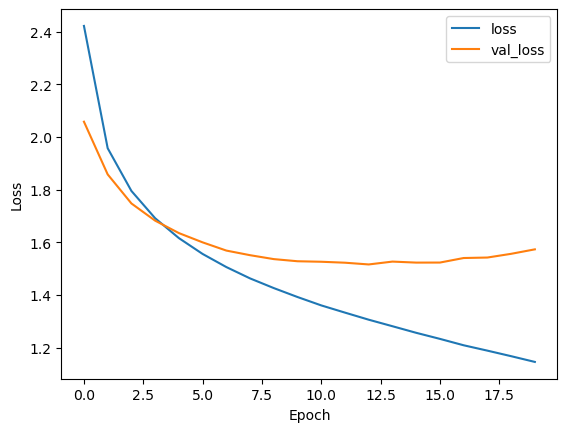

In [38]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #12

#### Hiddden units in layers : 64,32

In [40]:
model12 = keras.models.Sequential()
model12.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True))
model12.add(layers.GRU(64,return_sequences = True))
model12.add(layers.GRU(32))
model12.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model12.compile(loss='categorical_crossentropy', optimizer=optimizer)
model12.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_11 (GRU)                (None, 50, 128)           72576     
                                                                 
 gru_12 (GRU)                (None, 50, 64)            37248     
                                                                 
 gru_13 (GRU)                (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 59)                1947      
                                                                 
Total params: 121,179
Trainable params: 121,179
Non-trainable params: 0
_________________________________________________________________


In [41]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model12.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model12.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 417s 460ms/step - loss: 2.7391 - val_loss: 2.2554
epoch 2
895/895 [==============================] - 412s 461ms/step - loss: 2.0898 - val_loss: 1.9582
epoch 3
895/895 [==============================] - 413s 461ms/step - loss: 1.8880 - val_loss: 1.8259
epoch 4
895/895 [==============================] - 420s 469ms/step - loss: 1.7729 - val_loss: 1.7448
epoch 5
895/895 [==============================] - 422s 471ms/step - loss: 1.6873 - val_loss: 1.6871
--- Generating with seed: "er teach you how to block unfriendly spells,” said"
------ temperature: 0.5
er teach you how to block unfriendly spells,” said ron if the weasley to his being the wind into in the for the ranged himseling, it had feet was back to let heard the bulled the bit be a when it bely had in had have been at from and harry was at the said to to a gool it was the carting the wasting the raging the which herpify book the sight of the potters and they a shoor which be stoved 

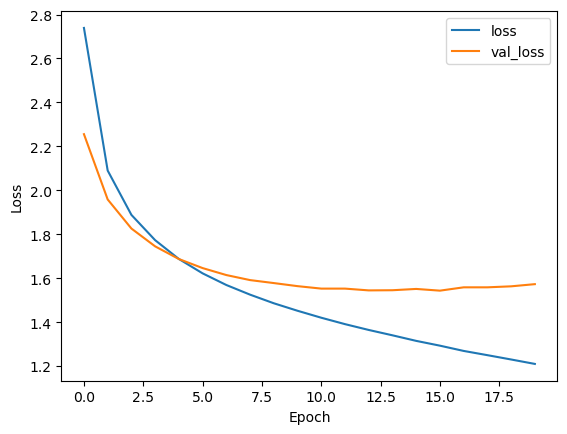

In [42]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #13

#### Dropout = 0.2 

#### No. of dropouts = 2

In [43]:
model13 = keras.models.Sequential()
model13.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True))
model13.add(layers.Dropout(0.2))
model13.add(layers.GRU(64))
model13.add(layers.Dropout(0.2))
model13.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model13.compile(loss='categorical_crossentropy', optimizer=optimizer)
model13.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 50, 128)           72576     
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 gru_15 (GRU)                (None, 64)                37248     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model13.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model13.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 940s 1s/step - loss: 2.5173 - val_loss: 2.1239
epoch 2
895/895 [==============================] - 800s 894ms/step - loss: 2.1003 - val_loss: 1.9323
epoch 3
895/895 [==============================] - 952s 1s/step - loss: 1.9624 - val_loss: 1.8248
epoch 4
895/895 [==============================] - 1035s 1s/step - loss: 1.8784 - val_loss: 1.7582
epoch 5
895/895 [==============================] - 832s 929ms/step - loss: 1.8171 - val_loss: 1.7091
--- Generating with seed: " body and legs, and each of the eyes on his ugly, "
------ temperature: 0.5
 body and legs, and each of the eyes on his ugly, morter handed and stiding, “i go now and could in the lick a sarow at the potting a masten and harry had beting the stall was and a now and sead leasly into the the fints and seat in hall in the dound the said, harry seaded it was at the done the foras and sinch that seement hind all said have been ard was was and and mosting to the said he said ha

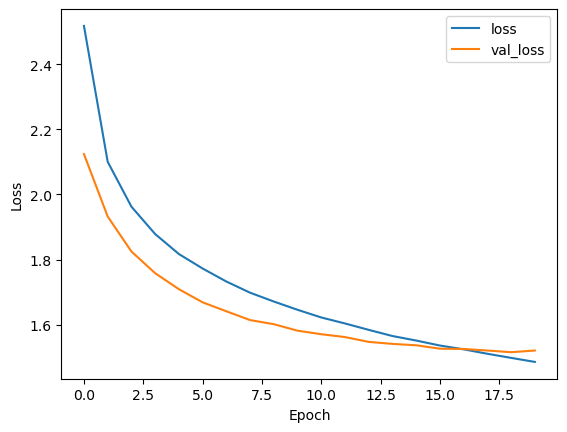

In [45]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #14

#### Dropout = 0.1

#### No. of dropouts = 2

In [21]:
model14 = keras.models.Sequential()
model14.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True))
model14.add(layers.Dropout(0.1))
model14.add(layers.GRU(64))
model14.add(layers.Dropout(0.1))
model14.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model14.compile(loss='categorical_crossentropy', optimizer=optimizer)
model14.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 50, 128)           72576     
                                                                 
 dropout_4 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model14.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model14.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 201s 215ms/step - loss: 2.4708 - val_loss: 2.0856
epoch 2
895/895 [==============================] - 187s 209ms/step - loss: 2.0235 - val_loss: 1.8864
epoch 3
895/895 [==============================] - 153s 171ms/step - loss: 1.8783 - val_loss: 1.7742
epoch 4
895/895 [==============================] - 166s 185ms/step - loss: 1.7910 - val_loss: 1.7050
epoch 5
895/895 [==============================] - 164s 183ms/step - loss: 1.7270 - val_loss: 1.6560
--- Generating with seed: "ing here and there at its scaly nose as the blood "
------ temperature: 0.5
ing here and there at its scaly nose as the blood of the long had had the chom as the carding the had shoot of his peeses and starting the back the back the cramber and dobby dracked the stants the durs of the stall had heard and harry that love a stid down the was and have seemed in a spaling the stapting the cears and harry took and stopped in and the carning the came and hermione shoute

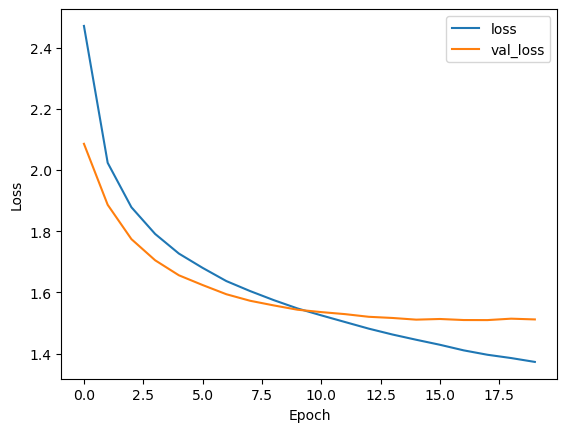

In [23]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #15

#### Dropout = 0.1

#### No. of dropouts = 1

In [24]:
model15 = keras.models.Sequential()
model15.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True))
model15.add(layers.Dropout(0.1))
model15.add(layers.GRU(64))
model15.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model15.compile(loss='categorical_crossentropy', optimizer=optimizer)
model15.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 50, 128)           72576     
                                                                 
 dropout_6 (Dropout)         (None, 50, 128)           0         
                                                                 
 gru_11 (GRU)                (None, 64)                37248     
                                                                 
 dense_5 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model15.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model15.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 174s 191ms/step - loss: 2.4484 - val_loss: 2.0892
epoch 2
895/895 [==============================] - 163s 182ms/step - loss: 1.9879 - val_loss: 1.8742
epoch 3
895/895 [==============================] - 166s 186ms/step - loss: 1.8266 - val_loss: 1.7550
epoch 4
895/895 [==============================] - 163s 182ms/step - loss: 1.7258 - val_loss: 1.6840
epoch 5
895/895 [==============================] - 171s 192ms/step - loss: 1.6545 - val_loss: 1.6374
--- Generating with seed: "s told him to catch the hogwarts express as usual "
------ temperature: 0.5
s told him to catch the hogwarts express as usual was had the stairs. hermione staided the pething them he was so have that can a stull of he was in the gryone siment up the floor the bell of the toping the from the car of the sperter and harry should harry was the corrints and he was in the sine got on the crimble harry be and harry ard it of the chome. “i’ve mean and see of for. harry pe

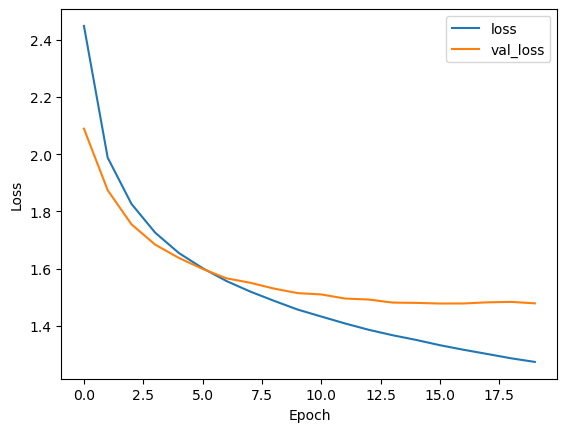

In [26]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #16

#### Recurrent Dropout = 0.1

#### No. of dropouts layers = 2

In [27]:
model16 = keras.models.Sequential()
model16.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model16.add(layers.GRU(64, recurrent_dropout=0.1))
model16.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model16.compile(loss='categorical_crossentropy', optimizer=optimizer)
model16.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 50, 128)           72576     
                                                                 
 gru_13 (GRU)                (None, 64)                37248     
                                                                 
 dense_6 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model16.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model16.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 367s 406ms/step - loss: 2.4614 - val_loss: 2.1045
epoch 2
895/895 [==============================] - 350s 391ms/step - loss: 1.9946 - val_loss: 1.8789
epoch 3
895/895 [==============================] - 354s 395ms/step - loss: 1.8272 - val_loss: 1.7703
epoch 4
895/895 [==============================] - 354s 395ms/step - loss: 1.7291 - val_loss: 1.6896
epoch 5
895/895 [==============================] - 352s 393ms/step - loss: 1.6638 - val_loss: 1.6406
--- Generating with seed: "ew yeh hadn’t really. i told lockhart yeh didn’ ne"
------ temperature: 0.5
ew yeh hadn’t really. i told lockhart yeh didn’ nearly. “what on his staisand. “it dank harry was every was had don’t her been a far and nearly had beach care the spreasser potten to sile is a show and the firch and say the did of the quickly. “the past the with his foog the seelly, but the curse on the dank the spected the car his had be at his when harry to see fleas, he was not his boug

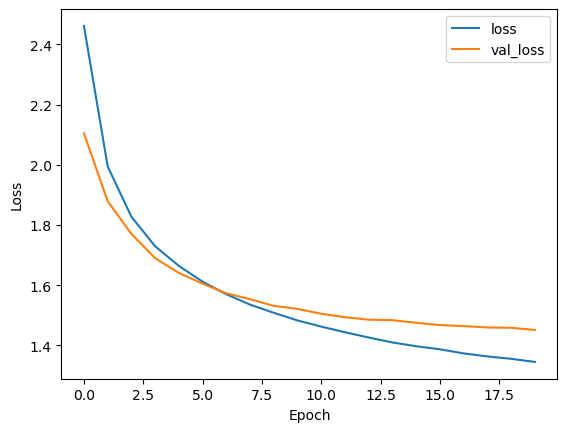

In [29]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #17

#### Recurrent dropout = 0.1

#### No. of dropouts layers = 1

In [30]:
model17 = keras.models.Sequential()
model17.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model17.add(layers.GRU(64))
model17.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model17.compile(loss='categorical_crossentropy', optimizer=optimizer)
model17.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 50, 128)           72576     
                                                                 
 gru_15 (GRU)                (None, 64)                37248     
                                                                 
 dense_7 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model17.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model17.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 792s 881ms/step - loss: 2.4512 - val_loss: 2.0957
epoch 2
895/895 [==============================] - 787s 879ms/step - loss: 1.9891 - val_loss: 1.8791
epoch 3
895/895 [==============================] - 794s 887ms/step - loss: 1.8200 - val_loss: 1.7566
epoch 4
895/895 [==============================] - 798s 892ms/step - loss: 1.7181 - val_loss: 1.6854
epoch 5
895/895 [==============================] - 796s 889ms/step - loss: 1.6490 - val_loss: 1.6359
--- Generating with seed: " “that was the one i burped slugs all over. if you"
------ temperature: 0.5
 “that was the one i burped slugs all over. if your wanted minters, and harry said he was the filch of sudder the first the row a speashed the sear harry some at the post of the stool be the tere harry seak breed of the firch and slithing to see feeling the care reaming the sears done corright to so the grinted the one been up and in all his mist on the goor light the stoof in the end book

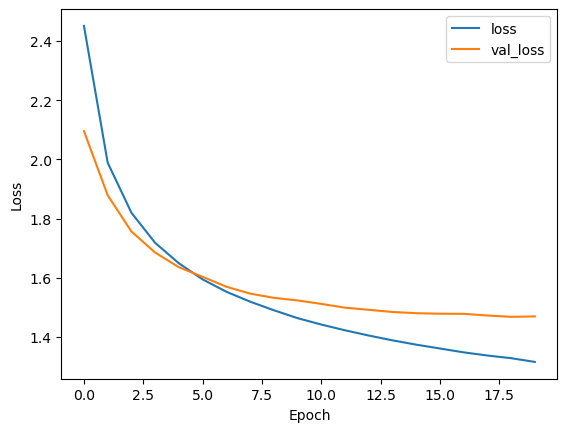

In [32]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #18

#### L1 Regularizer = 0.01

In [19]:
model18 = keras.models.Sequential()
model18.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, 
                       recurrent_dropout=0.1,kernel_regularizer=regularizers.l1(0.01)))
model18.add(layers.GRU(64, kernel_regularizer=regularizers.l1(0.01)))
model18.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model18.compile(loss='categorical_crossentropy', optimizer=optimizer)
model18.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 50, 128)           72576     
                                                                 
 gru_7 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model18.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model18.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 213s 233ms/step - loss: 4.5808 - val_loss: 3.0695
epoch 2
895/895 [==============================] - 195s 217ms/step - loss: 3.0798 - val_loss: 3.0701
epoch 3
895/895 [==============================] - 195s 217ms/step - loss: 3.0796 - val_loss: 3.0657
epoch 4
895/895 [==============================] - 189s 211ms/step - loss: 3.0784 - val_loss: 3.0700
epoch 5
895/895 [==============================] - 184s 205ms/step - loss: 3.0793 - val_loss: 3.0650
--- Generating with seed: "d. “you want to show a bit more respect to a schoo"
------ temperature: 0.5
d. “you want to show a bit more respect to a schoo al  o  eor n   t et  l  en  dt o      o       d dbn h    k   bk ea  aeot d e  s vh     la m  e  t  nm  eo eae ter f n    o d eo t e a ih e er rot  n  ya  a   a t   eet h dlytr   e w      r   e hrle   e d re   tt ol rn bt eeesenn  eyssd  r   o    n  oa h to orh  a   s  oo ha an      e san      ar oe   eeid  aa  t  ne   y o erus i,nae e o  n

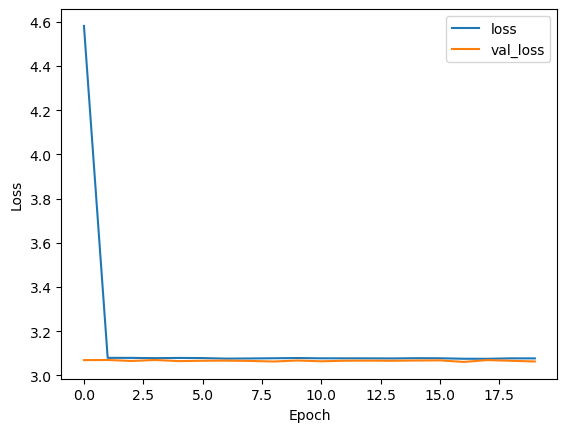

In [21]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #19

#### L1 Regularizer = 0.001

In [22]:
model19 = keras.models.Sequential()
model19.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, 
                       recurrent_dropout=0.1,kernel_regularizer=regularizers.l1(0.001)))
model19.add(layers.GRU(64, kernel_regularizer=regularizers.l1(0.001)))
model19.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model19.compile(loss='categorical_crossentropy', optimizer=optimizer)
model19.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 50, 128)           72576     
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model19.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model19.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 531s 589ms/step - loss: 3.2438 - val_loss: 3.0161
epoch 2
895/895 [==============================] - 531s 593ms/step - loss: 3.0257 - val_loss: 3.0142
epoch 3
895/895 [==============================] - 534s 597ms/step - loss: 3.0251 - val_loss: 3.0152
epoch 4
895/895 [==============================] - 533s 596ms/step - loss: 3.0255 - val_loss: 3.0152
epoch 5
895/895 [==============================] - 543s 607ms/step - loss: 3.0251 - val_loss: 3.0157
--- Generating with seed: ". ron, fred, and george seized harry’s arms and pu"
------ temperature: 0.5
. ron, fred, and george seized harry’s arms and pu   e   o  n  d s r t   d    td   shnere thn t  ase  to u e on doe oe    a   iw ea   scant  id   hetn e   oret e       na ,eeeeu e n  e e i en onetnts ho  .ti  e nsg   t   r le a e      tmke     t     oante   f  ankr  dsa e ea  u   .aoran  t  er han e   a d te     an.ae s   d  oo a  a   l e d    o o eec i  o ee    n  s   t  k n  aru m fe nf 

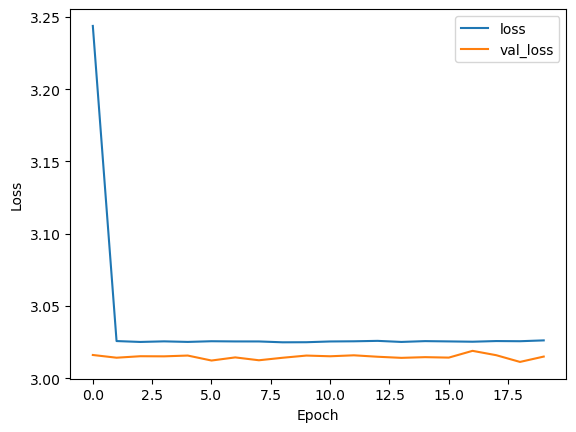

In [24]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #20

#### L2 Regularizer = 0.01

In [17]:
model20 = keras.models.Sequential()
model20.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, 
                       recurrent_dropout=0.1,kernel_regularizer=regularizers.l2(0.01)))
model20.add(layers.GRU(64, kernel_regularizer=regularizers.l2(0.01)))
model20.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model20.compile(loss='categorical_crossentropy', optimizer=optimizer)
model20.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           72576     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model20.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model20.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 360s 392ms/step - loss: 3.0631 - val_loss: 2.7801
epoch 2
895/895 [==============================] - 369s 413ms/step - loss: 2.7036 - val_loss: 2.6057
epoch 3
895/895 [==============================] - 343s 383ms/step - loss: 2.5788 - val_loss: 2.5292
epoch 4
895/895 [==============================] - 310s 346ms/step - loss: 2.5171 - val_loss: 2.4674
epoch 5
895/895 [==============================] - 317s 354ms/step - loss: 2.4684 - val_loss: 2.4284
--- Generating with seed: "was in the chamber of secrets. harry swung his leg"
------ temperature: 0.5
was in the chamber of secrets. harry swung his legled in whe wane in thinr yor m wame wes in the saud horry on on mkislad wer the the geet sin teos fat bif har a the ceone dfale wor lene darin and then and on wole the to he woug doscit toon the barr soot nos mere to the derined bol the enon tore he pink anc he thaog wither he bind nos in herren herribe at the bark ans the farred for and or

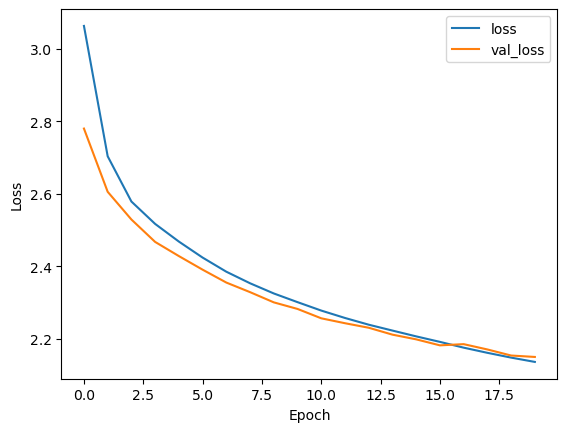

In [19]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #21

#### L2 Regularizer = 0.001

In [20]:
model21 = keras.models.Sequential()
model21.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, 
                       recurrent_dropout=0.1,kernel_regularizer=regularizers.l2(0.001)))
model21.add(layers.GRU(64, kernel_regularizer=regularizers.l2(0.001)))
model21.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model21.compile(loss='categorical_crossentropy', optimizer=optimizer)
model21.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50, 128)           72576     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model21.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model21.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 689s 766ms/step - loss: 2.6215 - val_loss: 2.3314
epoch 2
895/895 [==============================] - 929s 1s/step - loss: 2.2763 - val_loss: 2.1986
epoch 3
895/895 [==============================] - 843s 943ms/step - loss: 2.1658 - val_loss: 2.1116
epoch 4
895/895 [==============================] - 687s 768ms/step - loss: 2.0901 - val_loss: 2.0422
epoch 5
895/895 [==============================] - 751s 840ms/step - loss: 2.0337 - val_loss: 1.9984
--- Generating with seed: "ng to go back to some muggle orphanage if they clo"
------ temperature: 0.5
ng to go back to some muggle orphanage if they clome and the the eard of the hin in that harry me porled all hermione jutt and dading stearing he slat. harry said and the corn the to come the wrock the mart to the all he sting the hin him and the stile a doon the with he whis wisnout to a dinge of the could he stains of the evely harry mist and his med to the mast of it he was was lyould what

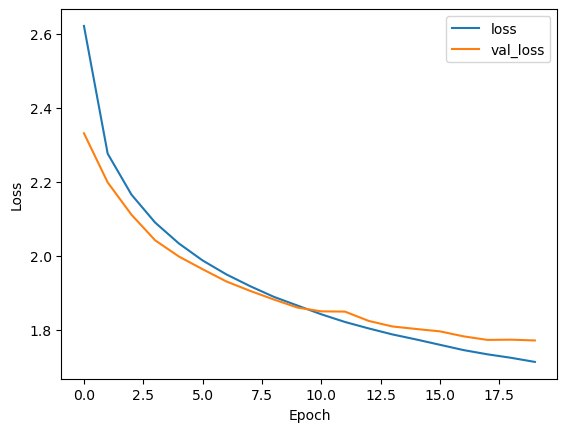

In [22]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #22

#### Optimizer = RMSprop

In [15]:
model22 = keras.models.Sequential()
model22.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model22.add(layers.GRU(64))
model22.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.RMSprop(learning_rate=0.001)
model22.compile(loss='categorical_crossentropy', optimizer=optimizer)
model22.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           72576     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model22.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model22.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 225s 246ms/step - loss: 2.5300 - val_loss: 2.2119
epoch 2
895/895 [==============================] - 283s 316ms/step - loss: 2.1048 - val_loss: 1.9970
epoch 3
895/895 [==============================] - 230s 257ms/step - loss: 1.9424 - val_loss: 1.8710
epoch 4
895/895 [==============================] - 223s 249ms/step - loss: 1.8344 - val_loss: 1.7896
epoch 5
895/895 [==============================] - 221s 247ms/step - loss: 1.7556 - val_loss: 1.7225
--- Generating with seed: "y flatly, glancing around to check that the room w"
------ temperature: 0.5
y flatly, glancing around to check that the room with his fars and harry spearing and let of the seet. “he was the was the canden up and looked his had never and sont on the was for she was hears for the been to harry hears and he had ron. “under a lick and said his sele reathing be the sompore the could rears and care around the started with to had beand it what he was the sond nose to se

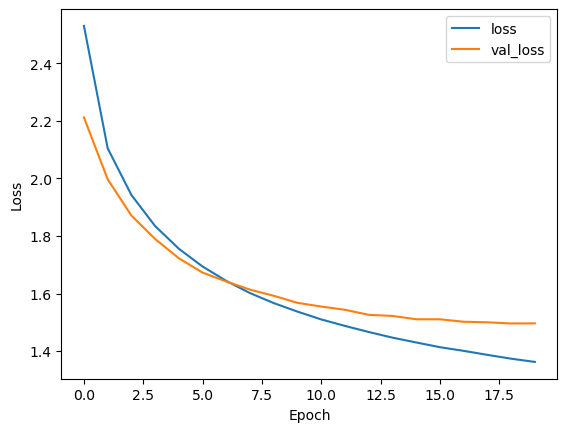

In [18]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #23

#### Sampling method: [Random Sampling](#rsample)    <a id="rsamplec"></a>


In [17]:
model23 = keras.models.Sequential()
model23.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model23.add(layers.GRU(64))
model23.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model23.compile(loss='categorical_crossentropy', optimizer=optimizer)
model23.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           72576     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model23.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model23.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = randomsample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 425s 457ms/step - loss: 2.4252 - val_loss: 2.0774
epoch 2
895/895 [==============================] - 369s 412ms/step - loss: 1.9771 - val_loss: 1.8687
epoch 3
895/895 [==============================] - 337s 376ms/step - loss: 1.8162 - val_loss: 1.7502
epoch 4
895/895 [==============================] - 332s 371ms/step - loss: 1.7201 - val_loss: 1.6868
epoch 5
895/895 [==============================] - 291s 325ms/step - loss: 1.6542 - val_loss: 1.6385
--- Generating with seed: "iddle. “but she finally became suspicious and trie"
------ temperature: 0.5
iddle. “but she finally became suspicious and tried a sight at the entt off his sperthed of the cursley for a serest and my find of the cander and the car some — ” “white a more the way to the grouse how with the grong the dirst the car the burned the fired had for and the crooked burge and malfoy treme and stained the fire and he was to one readume the grainted fire the bread a seet to he

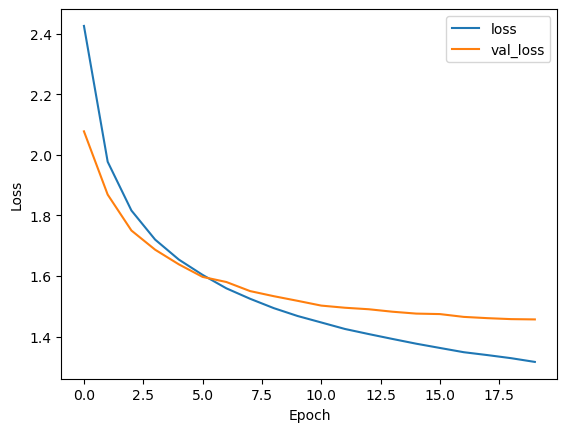

In [19]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #24

#### Sampling method: [Greedy Sampling](#gsample)    <a id="gsamplec"></a>


In [20]:
model24 = keras.models.Sequential()
model24.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model24.add(layers.GRU(64))
model24.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model24.compile(loss='categorical_crossentropy', optimizer=optimizer)
model24.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 50, 128)           72576     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_1 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model24.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.5, 1.0]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model24.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = greedysample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 658s 729ms/step - loss: 2.5029 - val_loss: 2.0991
epoch 2
895/895 [==============================] - 649s 726ms/step - loss: 1.9874 - val_loss: 1.8715
epoch 3
895/895 [==============================] - 646s 722ms/step - loss: 1.8215 - val_loss: 1.7583
epoch 4
895/895 [==============================] - 656s 733ms/step - loss: 1.7229 - val_loss: 1.6911
epoch 5
895/895 [==============================] - 645s 721ms/step - loss: 1.6535 - val_loss: 1.6425
--- Generating with seed: "d’ve gone up to the feast. ...” “she didn’t want u"
------ temperature: 0.5
d’ve gone up to the feast. ...” “she didn’t want up the could harry potter the could harry was a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a spall a

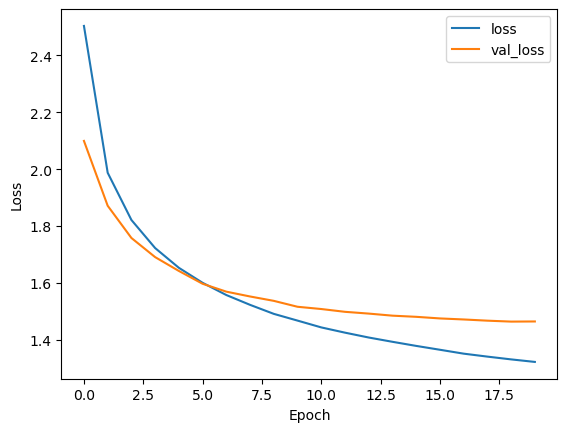

In [22]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #25

#### Tempearature: 0.4,0.6,0.8

In [14]:
model25 = keras.models.Sequential()
model25.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model25.add(layers.GRU(64))
model25.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model25.compile(loss='categorical_crossentropy', optimizer=optimizer)
model25.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 128)           72576     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model25.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.4,0.6,0.8]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model25.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 216s 241ms/step - loss: 3.0478 - val_loss: 3.0126
epoch 2
895/895 [==============================] - 222s 248ms/step - loss: 3.0215 - val_loss: 3.0124
epoch 3
895/895 [==============================] - 216s 241ms/step - loss: 3.0210 - val_loss: 3.0090
epoch 4
895/895 [==============================] - 204s 228ms/step - loss: 3.0207 - val_loss: 3.0103
epoch 5
895/895 [==============================] - 196s 219ms/step - loss: 3.0205 - val_loss: 3.0106
--- Generating with seed: "nate the diary was discovered, and riddle’s memori"
------ temperature: 0.4
nate the diary was discovered, and riddle’s memori oot   eo   eetsee  ae e o    ett  o o  ’et weetot be  rie   a   a te e    htt  a i   l l     r e ee   ie  t o    ao ei  ia lt   d eaeeaao  oo ee  to  oon   td eo   a d   r  os   beg eh  tdoehte oo o h a es     e  ee ie  e t    o  e e t   e ne  t    iet  oese he     otdhs a  d ea o    e oe r   rt e n  el eaen    to  s o ol  pre  e o  ro  i 

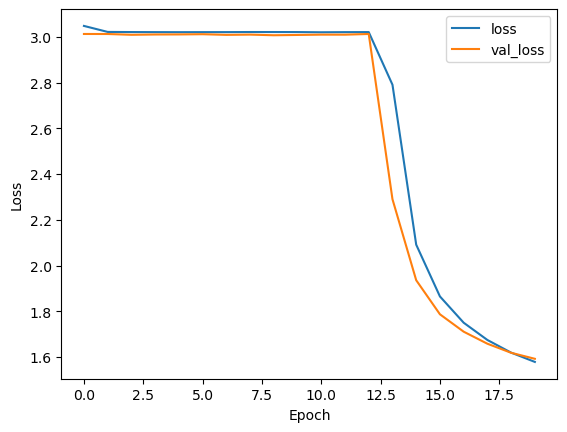

In [38]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model #26

#### Tempeature: 0.6

In [74]:
model26 = keras.models.Sequential()
model26.add(layers.GRU(128, input_shape=(window_size, len(chars)), return_sequences = True, recurrent_dropout=0.1))
model26.add(layers.GRU(64))
model26.add(layers.Dense(len(chars), activation='softmax'))

optimizer = optimizers.Adam(learning_rate=0.001)
model26.compile(loss='categorical_crossentropy', optimizer=optimizer)
model26.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 50, 128)           72576     
                                                                 
 gru_9 (GRU)                 (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 59)                3835      
                                                                 
Total params: 113,659
Trainable params: 113,659
Non-trainable params: 0
_________________________________________________________________


In [58]:
# Initialize lists to store the loss and validation loss values
loss_history = []
val_loss_history = []

for epoch in range(1, 21):
    print('epoch', epoch)

    history= model26.fit(x, y,
              batch_size=128,
              epochs=1,
              validation_split=0.3)
    loss_history.append(history.history['loss'][0])
    val_loss_history.append(history.history['val_loss'][0])

    # Only print generated text every 5 epochs
    if epoch % 5 == 0:
        # Select a text seed at random
        start_index = random.randint(0, len(text) - window_size - 1)
        generated_text_initial = text[start_index: start_index + window_size]
        print('--- Generating with seed: "' + generated_text_initial + '"')

        for temperature in [0.6]:
            generated_text = generated_text_initial
            print('------ temperature:', temperature)
            sys.stdout.write(generated_text)

            # We generate 400 characters
            for i in range(400):
                sampled = np.zeros((1, window_size, len(chars)))
                for t, char in enumerate(generated_text):
                    sampled[0, t, char_indices[char]] = 1.

                preds = model26.predict(sampled, verbose=0)[0] # to get the softmax output
                next_index = sample(preds, temperature)
                next_char = chars[next_index]

                generated_text += next_char
                generated_text = generated_text[1:]

                sys.stdout.write(next_char)
                sys.stdout.flush()

        # Calculate the BLEU score
        generated_sentences = [generated_text]
        bleu_score = corpus_bleu(reference_texts, generated_sentences)
        print("BLEU score: ", bleu_score)
        print()

epoch 1
895/895 [==============================] - 237s 261ms/step - loss: 2.4627 - val_loss: 2.0864
epoch 2
895/895 [==============================] - 205s 229ms/step - loss: 1.9735 - val_loss: 1.8627
epoch 3
895/895 [==============================] - 203s 227ms/step - loss: 1.8092 - val_loss: 1.7470
epoch 4
895/895 [==============================] - 253s 283ms/step - loss: 1.7130 - val_loss: 1.6793
epoch 5
895/895 [==============================] - 222s 248ms/step - loss: 1.6446 - val_loss: 1.6375
--- Generating with seed: " he would be quite within the law to do that, even"
------ temperature: 0.6
 he would be quite within the law to do that, even the thought and harry had never a stunced of the fire you’ve be a ron a was his harry sell a shacked a serfor whith to ron had been doin of the croke you’ve the finch the parted the end spented the could he was of the decond wizard to a gryffinitus sturpled the was to ho she was the most to the rive for the sort lockhart and to come the en

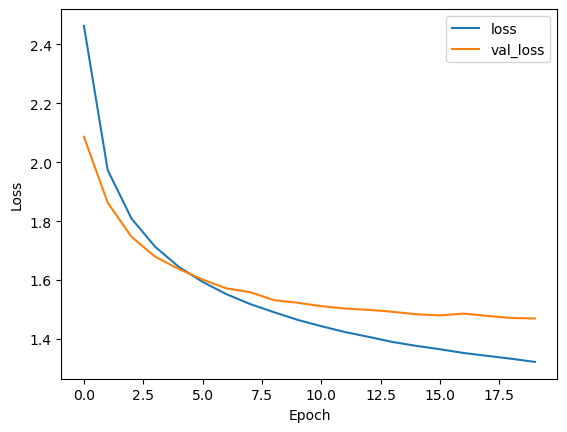

In [59]:
# Plot the loss and validation loss values over the epochs
import matplotlib.pyplot as plt

plt.plot(loss_history, label='loss')
plt.plot(val_loss_history, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Step 3 – Use the developed Model to generate the characters / sentences <a id="part3"></a>

In [63]:
# takes the user input
text_input = np.array([input()])

Harry stood in front of the Gryffindor common room, thinking about the tasks he needed to complete for Professor McGonagall. He had to finish his Transfiguration homework and study for his upcoming potions exam. But first, he needed to grab a quick bite to eat.


In [64]:
for i in range(400):
    sampled = np.zeros((1, window_size, len(chars)))
    for t, char in enumerate(generated_text):
        sampled[0, t, char_indices[char]] = 1.

    preds = model26.predict(sampled, verbose=0)[0] # to get the softmax output
    next_index = sample(preds, temperature)
    next_char = chars[next_index]

    generated_text += next_char
    generated_text = generated_text[1:]

    sys.stdout.write(next_char)
    sys.stdout.flush()


hake mudble so of the stoots, malfoy finches all manage, whatering and scratched the little all why arrive to manish fell of face. “i don’t think it’s never seemed to harry potter had can the first the counterse let me seemed to the asks and no in the office, it’s no iduries, and madam so the scone with in the car explaining in his wand, him. “i don’t know it was stay to sign, harry looked down th

[back to top](#top)